# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania zadań domowych.

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Extracting ./cifar-10-python.tar.gz to .

CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


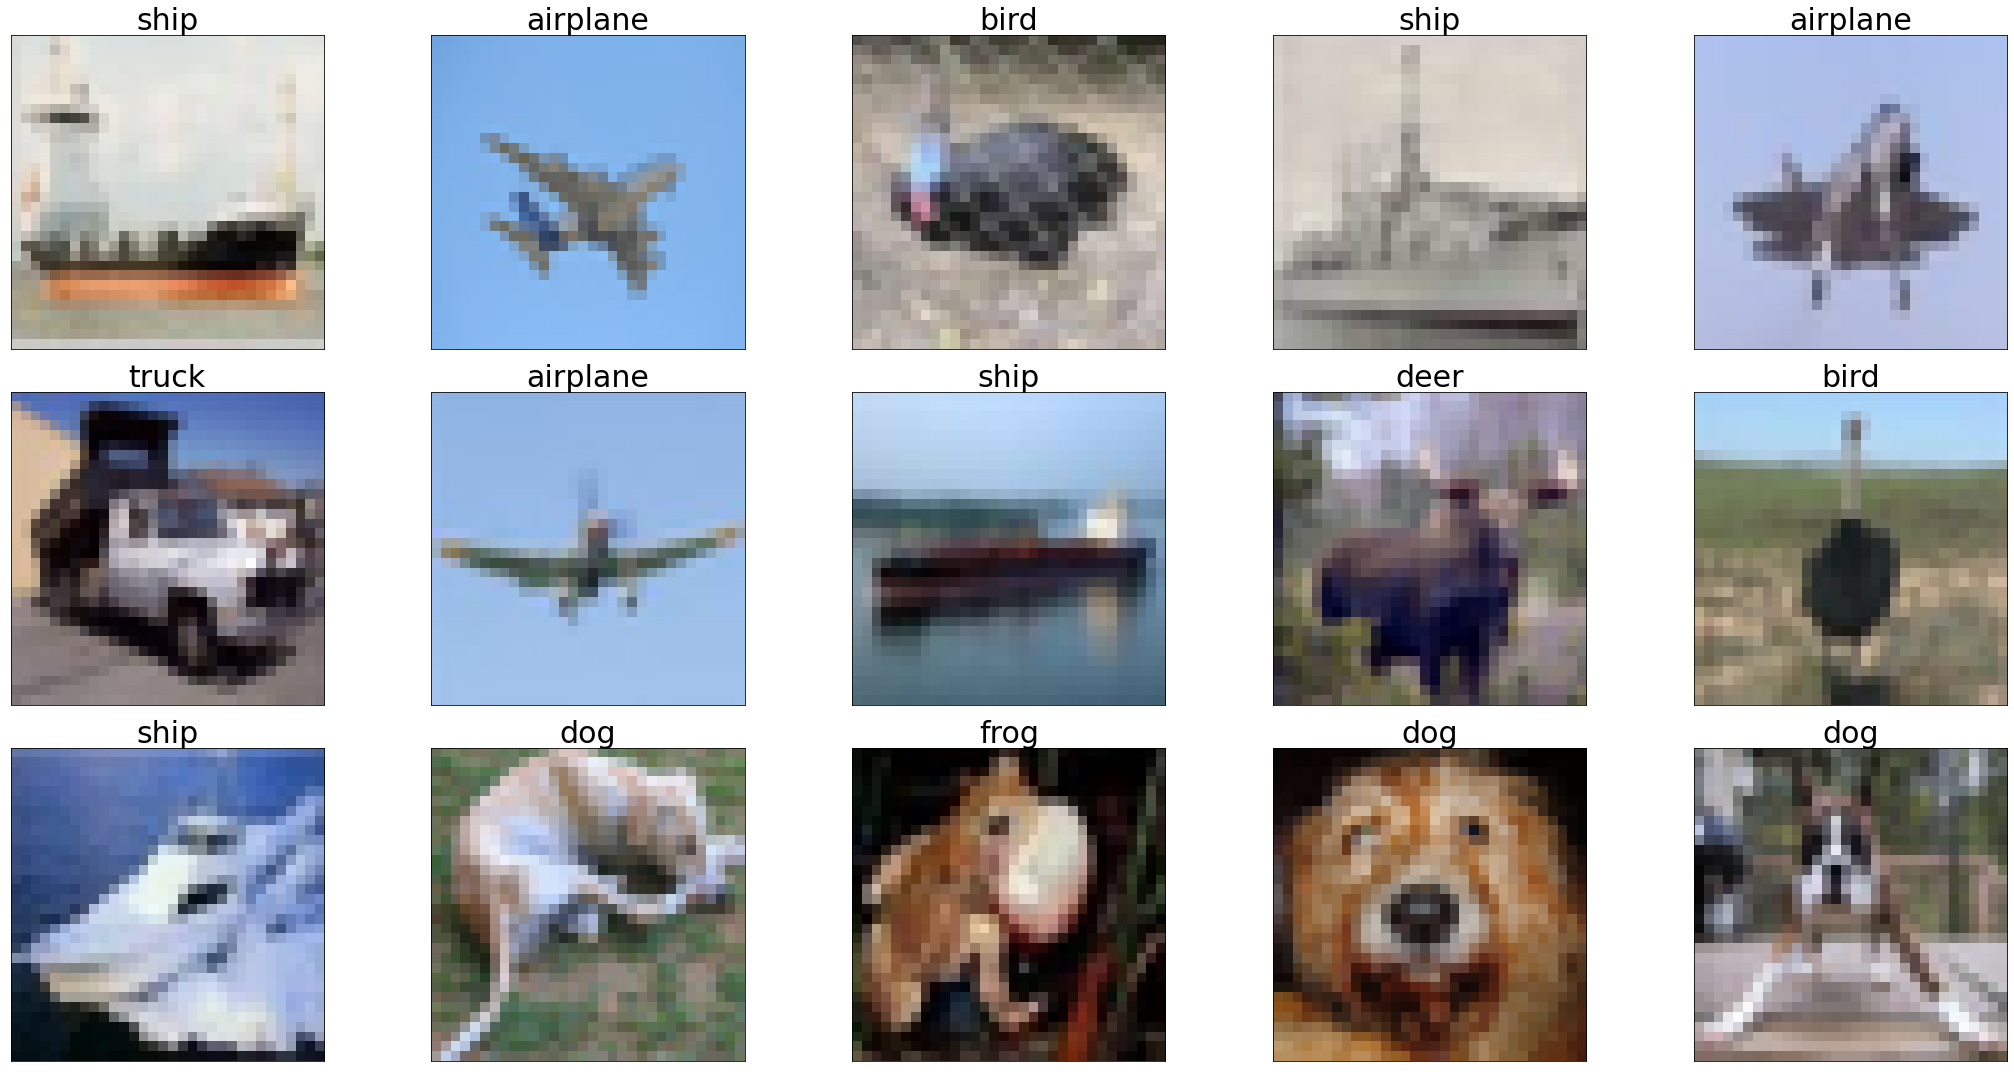

In [2]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# preapre visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [5]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module
class Cifar10Classifier(torch.nn.Module):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 0),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Conv2d(32, 64, 3, 1, 0),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2),

            # tyle samo channeli i stride=2 zamiast maxpoola
            torch.nn.Conv2d(64, 64, 2, 2, 0),

            torch.nn.Conv2d(64, 128, 3, 1, 0),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(0.1),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Conv2d(128, 256, 3, 1, 0),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(0.2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Conv2d(256, 256, 2, 2, 0),

            torch.nn.Conv2d(256, 512, 3, 1, 0),
            torch.nn.BatchNorm2d(512),
            torch.nn.Dropout(0.3),
            torch.nn.LeakyReLU(0.2),
        
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(4608, 10),
            torch.nn.Softmax(1),
        )
    
    def forward(self, x):
        return self.model(x)


In [3]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

# optymalne odchylenie i średnia dla każdego kanału wzięte z internetu
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor(), Normalize(mean=mean, std=std)]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor(), Normalize(mean=mean, std=std)]))


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [6]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
use_tqdm = True
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    use_tqdm = False
    print("tqdm not installed, using print")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if DEVICE == "cuda:0":
    print("Current cuda device: ",torch.cuda.get_device_name(0))

def train(model, optim, criterion, train_loader, test_loader, epochs):
    model.train()
    train_stats = {'loss': [], 'acc': []}
    test_stats = {'loss': [], 'acc': []}

    test_data = iter(train_loader)
    test_batch = test_data.next()
    val_batch = test_data.next()
    for i in range(epochs):
        if use_tqdm:
            pb = tqdm(enumerate(iter(train_loader)), total = len(train_loader))
            pb.set_description(f"epoch {i}/{epochs}")
        else:
            print(f"epoch {i}/{epochs}", end="")
            pb = enumerate(iter(train_loader))

        # iterate over all batches
        avg_loss, avg_acc = 0, 0
        for j, (x, labels) in pb:
            optim.zero_grad()
            x, labels = x.to(DEVICE), labels.to(DEVICE)
            probs = model(x)
            loss = criterion(probs, labels)
            loss.backward()
            optim.step()

            # zapisywanie danych
            acc = (torch.argmax(probs, dim=1) == labels).sum() / len(labels)
            avg_loss += float(loss / len(train_loader))
            avg_acc += float(acc / len(train_loader))
        train_stats['loss'].append(avg_loss)
        train_stats['acc'].append(avg_acc)

        # test na pierwszym batchu z test setu
        test_imgs, test_labels = test_batch
        test_imgs, test_labels = test_imgs.to(DEVICE), test_labels.to(DEVICE)
        model.eval()
        test_pr = model(test_imgs)
        test_loss = criterion(test_pr, test_labels)

        # zapisywanie danych
        test_acc = (torch.argmax(test_pr, dim=1) == test_labels).sum() / len(test_labels)
        test_stats['loss'].append(float(test_loss))
        test_stats['acc'].append(float(test_acc))
        model.train()

        msg = "train_loss: %.2f, train_acc: %.2f, test_loss: %.2f, test_acc: %.2f" % (avg_loss, avg_acc, test_loss, test_acc)
        if use_tqdm:
            pb.write(msg)
        else:
            print(msg)
    model.eval()

    # walidacja na drugim batchu z test setu
    # nigdy nie widziany podczas treningu
    val_imgs, val_labels = val_batch
    val_imgs, val_labels = val_imgs.to(DEVICE), val_labels.to(DEVICE)
    val_pr = model(val_imgs)
    val_loss = criterion(val_pr, val_labels)
    val_acc = (torch.argmax(val_pr, dim=1) == val_labels).sum() / len(val_labels)
    print("val_loss: %.2f, val_acc: %.2f" % (val_loss, val_acc))

    return train_stats, test_stats

classifier = Cifar10Classifier()
classifier.to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()
EPOCHS = 50

stats = train(classifier, optimizer, criterion, train_loader, test_loader, epochs=EPOCHS)


train_loss: 1.99, train_acc: 0.47, test_loss: 1.85, test_acc: 0.63



train_loss: 1.88, train_acc: 0.59, test_loss: 1.84, test_acc: 0.61



train_loss: 1.82, train_acc: 0.64, test_loss: 1.79, test_acc: 0.67



train_loss: 1.79, train_acc: 0.67, test_loss: 1.74, test_acc: 0.73



train_loss: 1.76, train_acc: 0.70, test_loss: 1.75, test_acc: 0.71



train_loss: 1.74, train_acc: 0.72, test_loss: 1.70, test_acc: 0.77



train_loss: 1.73, train_acc: 0.74, test_loss: 1.74, test_acc: 0.73



train_loss: 1.72, train_acc: 0.75, test_loss: 1.67, test_acc: 0.80



train_loss: 1.70, train_acc: 0.76, test_loss: 1.68, test_acc: 0.77



train_loss: 1.70, train_acc: 0.77, test_loss: 1.65, test_acc: 0.82



train_loss: 1.68, train_acc: 0.78, test_loss: 1.65, test_acc: 0.83



train_loss: 1.68, train_acc: 0.79, test_loss: 1.62, test_acc: 0.85



train_loss: 1.67, train_acc: 0.79, test_loss: 1.64, test_acc: 0.81



train_loss: 1.66, train_acc: 0.81, test_loss: 1.63, test_acc: 0.84



train_loss: 1.66, train_acc: 0.81, test_loss: 1.63, test_acc: 0.83



train_loss: 1.65, train_acc: 0.82, test_loss: 1.60, test_acc: 0.88



train_loss: 1.65, train_acc: 0.82, test_loss: 1.64, test_acc: 0.84



train_loss: 1.64, train_acc: 0.83, test_loss: 1.62, test_acc: 0.84



train_loss: 1.63, train_acc: 0.83, test_loss: 1.61, test_acc: 0.84



train_loss: 1.63, train_acc: 0.84, test_loss: 1.63, test_acc: 0.83



train_loss: 1.63, train_acc: 0.84, test_loss: 1.63, test_acc: 0.83



train_loss: 1.62, train_acc: 0.85, test_loss: 1.61, test_acc: 0.86



train_loss: 1.61, train_acc: 0.85, test_loss: 1.60, test_acc: 0.87



train_loss: 1.61, train_acc: 0.85, test_loss: 1.55, test_acc: 0.91



train_loss: 1.61, train_acc: 0.86, test_loss: 1.59, test_acc: 0.88



train_loss: 1.60, train_acc: 0.86, test_loss: 1.55, test_acc: 0.91



train_loss: 1.60, train_acc: 0.86, test_loss: 1.59, test_acc: 0.88



train_loss: 1.60, train_acc: 0.87, test_loss: 1.57, test_acc: 0.89



train_loss: 1.59, train_acc: 0.87, test_loss: 1.58, test_acc: 0.88



train_loss: 1.59, train_acc: 0.87, test_loss: 1.56, test_acc: 0.91



train_loss: 1.59, train_acc: 0.88, test_loss: 1.56, test_acc: 0.90



train_loss: 1.59, train_acc: 0.88, test_loss: 1.57, test_acc: 0.88



train_loss: 1.58, train_acc: 0.88, test_loss: 1.55, test_acc: 0.91



train_loss: 1.58, train_acc: 0.88, test_loss: 1.56, test_acc: 0.91



train_loss: 1.58, train_acc: 0.89, test_loss: 1.56, test_acc: 0.91



train_loss: 1.57, train_acc: 0.89, test_loss: 1.57, test_acc: 0.88



train_loss: 1.57, train_acc: 0.89, test_loss: 1.57, test_acc: 0.89



train_loss: 1.57, train_acc: 0.90, test_loss: 1.56, test_acc: 0.91



train_loss: 1.57, train_acc: 0.90, test_loss: 1.55, test_acc: 0.91



train_loss: 1.57, train_acc: 0.90, test_loss: 1.53, test_acc: 0.95



train_loss: 1.56, train_acc: 0.90, test_loss: 1.56, test_acc: 0.90



train_loss: 1.56, train_acc: 0.90, test_loss: 1.54, test_acc: 0.91



train_loss: 1.56, train_acc: 0.91, test_loss: 1.54, test_acc: 0.92



train_loss: 1.56, train_acc: 0.91, test_loss: 1.55, test_acc: 0.91



train_loss: 1.56, train_acc: 0.91, test_loss: 1.53, test_acc: 0.94



train_loss: 1.55, train_acc: 0.91, test_loss: 1.54, test_acc: 0.93



train_loss: 1.55, train_acc: 0.91, test_loss: 1.54, test_acc: 0.93



train_loss: 1.55, train_acc: 0.91, test_loss: 1.54, test_acc: 0.93



train_loss: 1.55, train_acc: 0.92, test_loss: 1.54, test_acc: 0.94



train_loss: 1.55, train_acc: 0.92, test_loss: 1.52, test_acc: 0.95
val_loss: 1.57, val_acc: 0.90


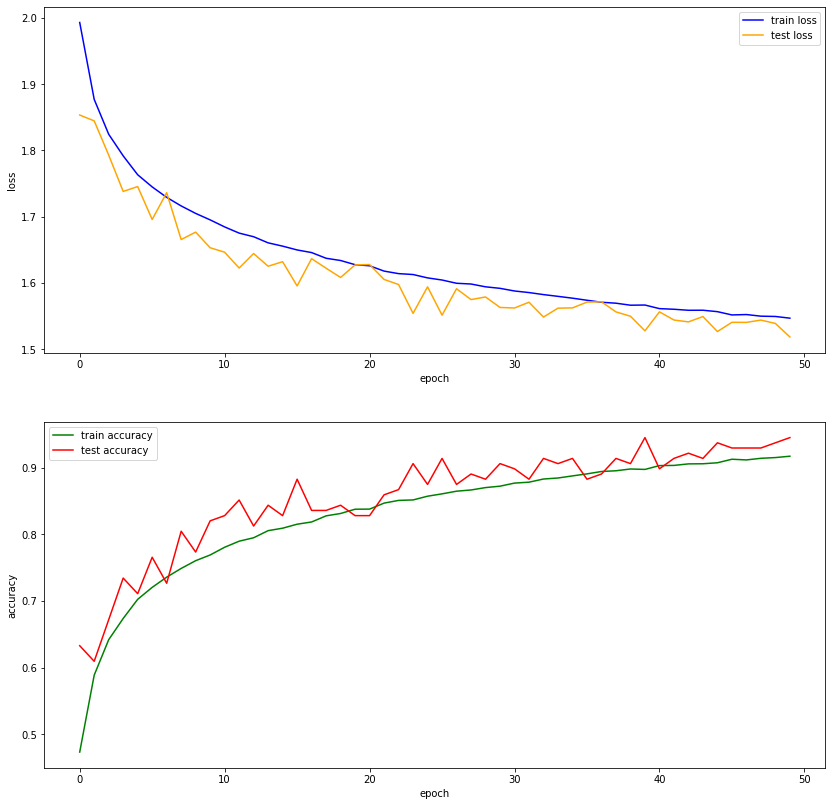

In [47]:
fig, (p1, p2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

p1.plot(stats[0]['loss'], color='blue', label="train loss")
p1.plot(stats[1]['loss'], color='orange', label="test loss")
p1.set_xlabel("epoch")
p1.set_ylabel("loss")
p1.legend()

p2.plot(stats[0]['acc'], color='green', label="train accuracy")
p2.plot(stats[1]['acc'], color='red', label="test accuracy")
p2.set_xlabel("epoch")
p2.set_ylabel("accuracy")
p2.legend()

plt.show()

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

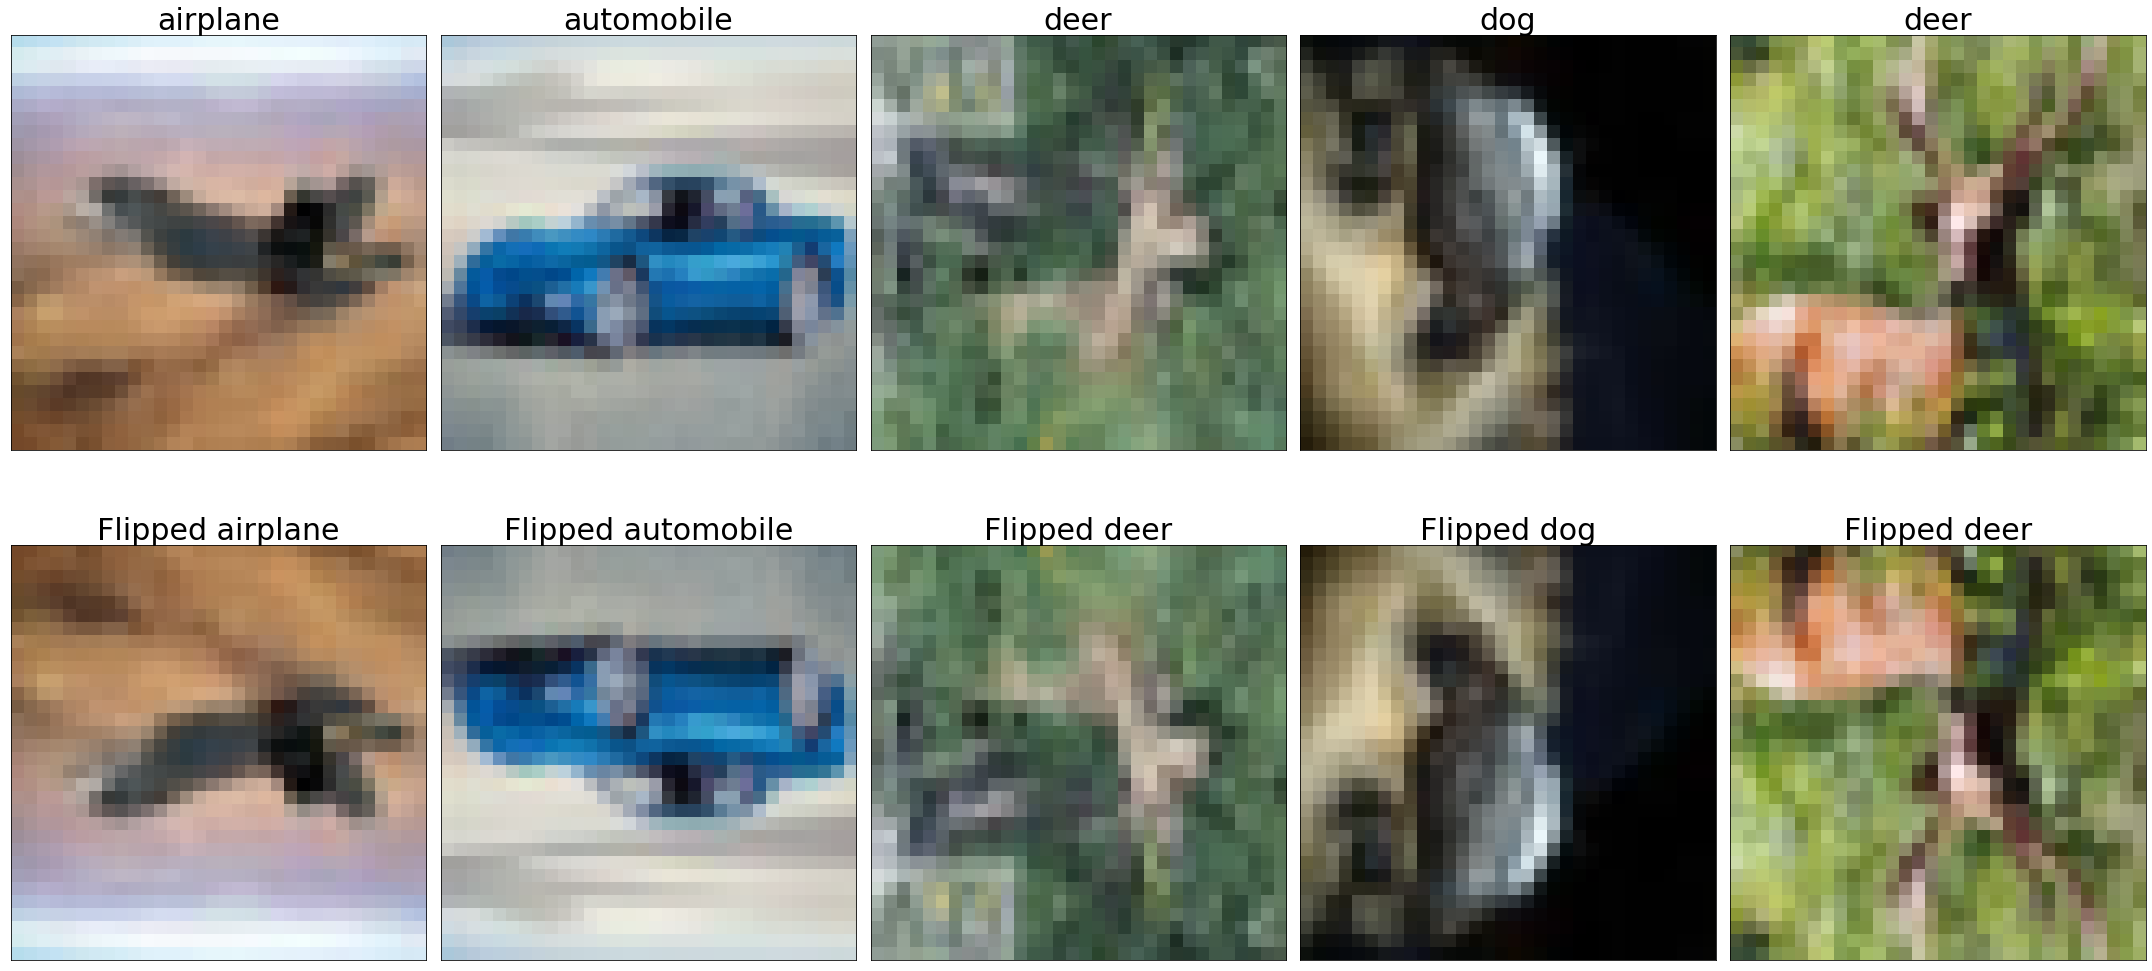

In [8]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [9]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

from torchvision.transforms import RandomHorizontalFlip, RandomRotation

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor(),
                                           RandomHorizontalFlip(0.3),
                                           RandomRotation(10),
                                           Normalize(mean=mean, std=std)]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor(), Normalize(mean=mean, std=std)]))


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# tutaj powtórz pętle uczenia z poprzedniego zadania
classifier_aug = Cifar10Classifier()
classifier_aug.to(DEVICE)
optim_aug = torch.optim.Adam(classifier_aug.parameters(), lr=0.0002)
criterion_aug = torch.nn.CrossEntropyLoss()
EPOCHS_AUG = 50

stats_aug = train(classifier_aug, optim_aug, criterion_aug, train_loader, test_loader, epochs=EPOCHS_AUG)


train_loss: 2.01, train_acc: 0.45, test_loss: 1.95, test_acc: 0.51



train_loss: 1.90, train_acc: 0.57, test_loss: 1.84, test_acc: 0.62



train_loss: 1.85, train_acc: 0.61, test_loss: 1.75, test_acc: 0.72



train_loss: 1.82, train_acc: 0.64, test_loss: 1.75, test_acc: 0.73



train_loss: 1.80, train_acc: 0.67, test_loss: 1.80, test_acc: 0.66



train_loss: 1.78, train_acc: 0.68, test_loss: 1.74, test_acc: 0.73



train_loss: 1.76, train_acc: 0.70, test_loss: 1.72, test_acc: 0.74



train_loss: 1.75, train_acc: 0.71, test_loss: 1.67, test_acc: 0.80



train_loss: 1.74, train_acc: 0.72, test_loss: 1.67, test_acc: 0.82



train_loss: 1.74, train_acc: 0.73, test_loss: 1.71, test_acc: 0.75



train_loss: 1.73, train_acc: 0.74, test_loss: 1.68, test_acc: 0.77



train_loss: 1.72, train_acc: 0.74, test_loss: 1.69, test_acc: 0.77



train_loss: 1.71, train_acc: 0.75, test_loss: 1.65, test_acc: 0.83



train_loss: 1.71, train_acc: 0.76, test_loss: 1.68, test_acc: 0.80



train_loss: 1.70, train_acc: 0.76, test_loss: 1.66, test_acc: 0.80



train_loss: 1.70, train_acc: 0.76, test_loss: 1.70, test_acc: 0.74



train_loss: 1.69, train_acc: 0.77, test_loss: 1.67, test_acc: 0.78



train_loss: 1.69, train_acc: 0.77, test_loss: 1.69, test_acc: 0.77



train_loss: 1.69, train_acc: 0.77, test_loss: 1.64, test_acc: 0.84



train_loss: 1.68, train_acc: 0.78, test_loss: 1.65, test_acc: 0.82



train_loss: 1.68, train_acc: 0.79, test_loss: 1.63, test_acc: 0.83



train_loss: 1.67, train_acc: 0.79, test_loss: 1.64, test_acc: 0.83



train_loss: 1.67, train_acc: 0.79, test_loss: 1.64, test_acc: 0.82



train_loss: 1.67, train_acc: 0.79, test_loss: 1.63, test_acc: 0.82



train_loss: 1.67, train_acc: 0.79, test_loss: 1.64, test_acc: 0.84



train_loss: 1.66, train_acc: 0.80, test_loss: 1.62, test_acc: 0.84



train_loss: 1.66, train_acc: 0.80, test_loss: 1.64, test_acc: 0.83



train_loss: 1.66, train_acc: 0.80, test_loss: 1.65, test_acc: 0.80



train_loss: 1.66, train_acc: 0.81, test_loss: 1.63, test_acc: 0.84



train_loss: 1.65, train_acc: 0.81, test_loss: 1.64, test_acc: 0.82



train_loss: 1.65, train_acc: 0.81, test_loss: 1.62, test_acc: 0.85



train_loss: 1.65, train_acc: 0.81, test_loss: 1.62, test_acc: 0.84



train_loss: 1.65, train_acc: 0.82, test_loss: 1.61, test_acc: 0.84



train_loss: 1.65, train_acc: 0.82, test_loss: 1.60, test_acc: 0.88



train_loss: 1.65, train_acc: 0.82, test_loss: 1.65, test_acc: 0.81



train_loss: 1.64, train_acc: 0.82, test_loss: 1.62, test_acc: 0.84



train_loss: 1.64, train_acc: 0.82, test_loss: 1.64, test_acc: 0.83



train_loss: 1.64, train_acc: 0.82, test_loss: 1.60, test_acc: 0.87



train_loss: 1.64, train_acc: 0.83, test_loss: 1.64, test_acc: 0.82



train_loss: 1.63, train_acc: 0.83, test_loss: 1.60, test_acc: 0.88



train_loss: 1.63, train_acc: 0.83, test_loss: 1.61, test_acc: 0.85



train_loss: 1.63, train_acc: 0.83, test_loss: 1.61, test_acc: 0.85



train_loss: 1.63, train_acc: 0.83, test_loss: 1.63, test_acc: 0.83



train_loss: 1.63, train_acc: 0.83, test_loss: 1.62, test_acc: 0.84



train_loss: 1.63, train_acc: 0.84, test_loss: 1.59, test_acc: 0.85



train_loss: 1.63, train_acc: 0.84, test_loss: 1.61, test_acc: 0.85



train_loss: 1.63, train_acc: 0.84, test_loss: 1.63, test_acc: 0.83



train_loss: 1.62, train_acc: 0.84, test_loss: 1.59, test_acc: 0.87



train_loss: 1.62, train_acc: 0.84, test_loss: 1.59, test_acc: 0.88



train_loss: 1.62, train_acc: 0.84, test_loss: 1.59, test_acc: 0.87
val_loss: 1.61, val_acc: 0.84


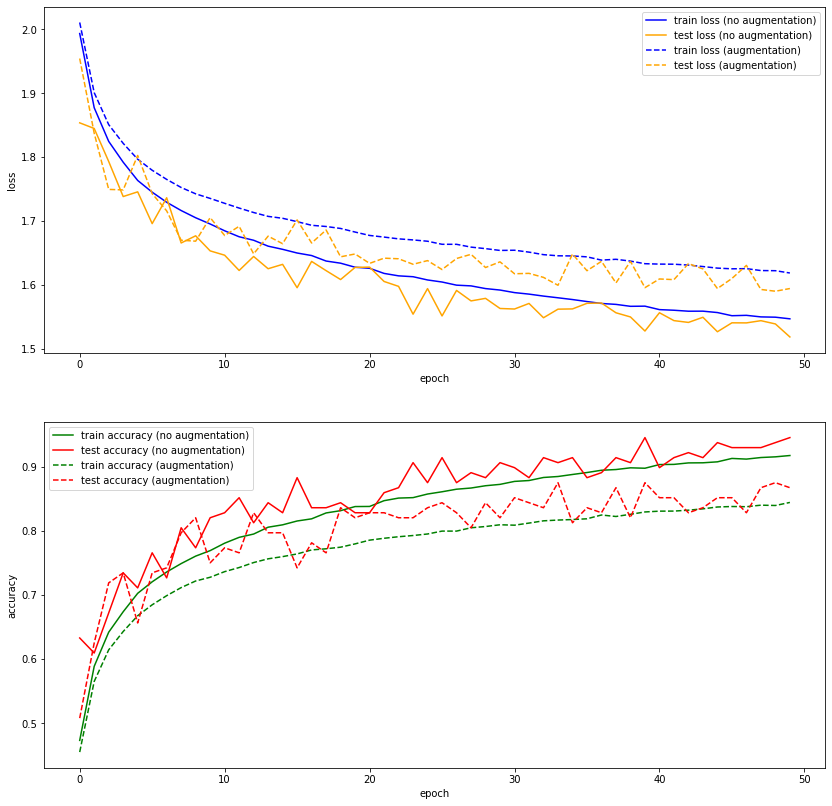

In [15]:
fig, (p1, p2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

p1.plot(stats[0]['loss'], color='blue', label="train loss (no augmentation)")
p1.plot(stats[1]['loss'], color='orange', label="test loss (no augmentation)")
p1.plot(stats_aug[0]['loss'], color='blue', label="train loss (augmentation)", linestyle="--")
p1.plot(stats_aug[1]['loss'], color='orange', label="test loss (augmentation)", linestyle="--")
p1.set_xlabel("epoch")
p1.set_ylabel("loss")
p1.legend()

p2.plot(stats[0]['acc'], color='green', label="train accuracy (no augmentation)")
p2.plot(stats[1]['acc'], color='red', label="test accuracy (no augmentation)")
p2.plot(stats_aug[0]['acc'], color='green', label="train accuracy (augmentation)", linestyle="--")
p2.plot(stats_aug[1]['acc'], color='red', label="test accuracy (augmentation)", linestyle="--")
p2.set_xlabel("epoch")
p2.set_ylabel("accuracy")
p2.legend()

plt.show()
# model zdaje się wolniej zbiegać przez szum spowodowany losowymi augmentacjami
# być może potrzebuje dłuższego treningu by osiągnąć lepszy wynik od modelu bez augmentacji

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [16]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [17]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


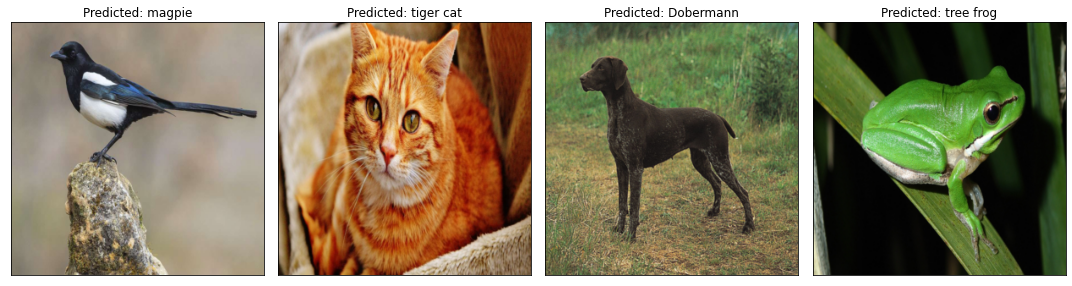

In [18]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [19]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
#eps = 0.02
eps = 0.184403125 # spowoduje dość mocne zaszumienie zdjęć i pomyłkę przy zdjęciu sroki

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

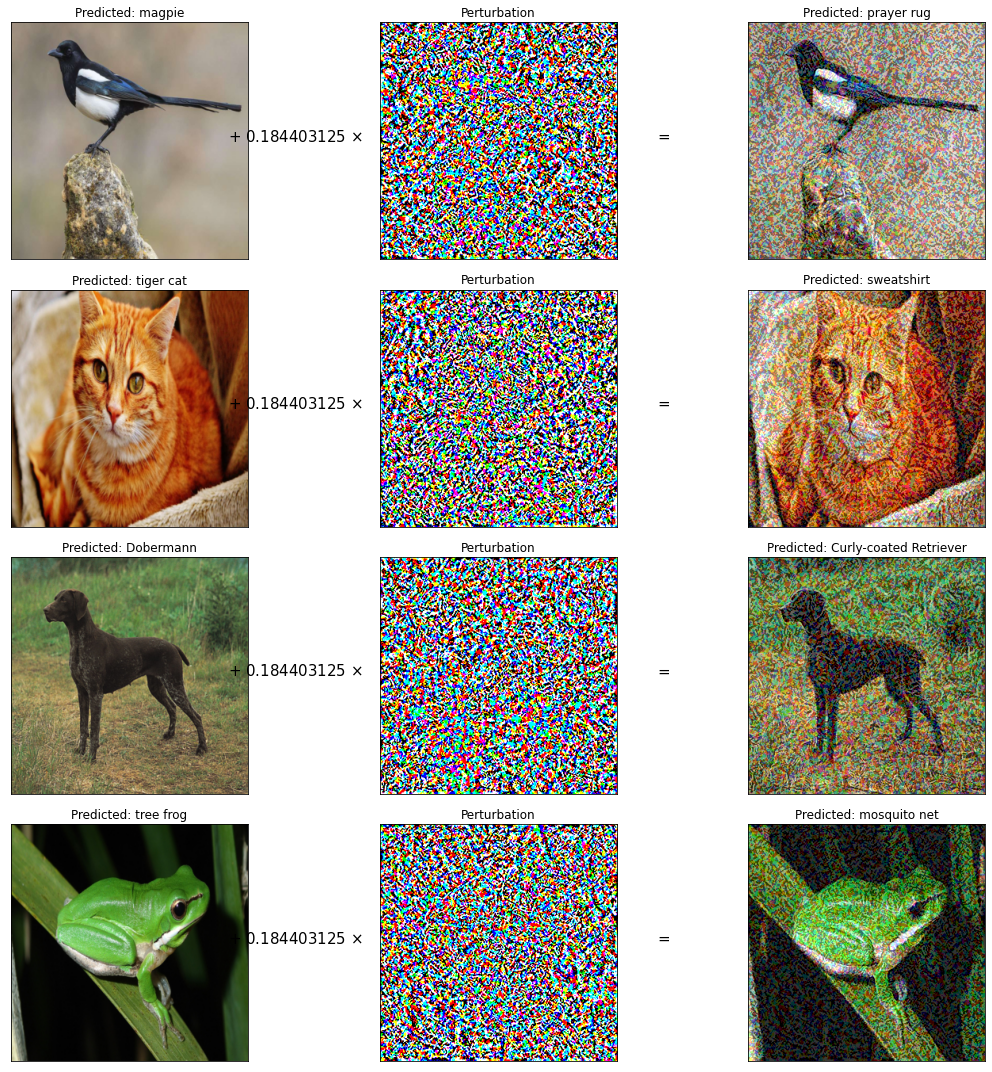

In [20]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizacje znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji 

Files already downloaded and verified


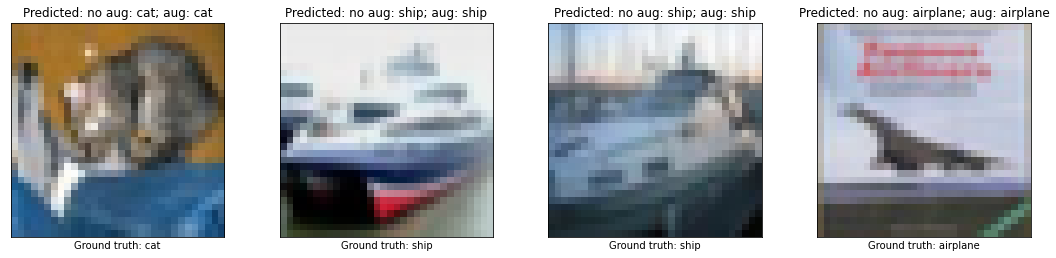

In [31]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!

# 1. eps = 0.184403125 jest najmniejszym jakie znalazłem

std = torch.Tensor(std)
mean = torch.Tensor(mean)
test_dataset = CIFAR10(root='.', train=False, download=True,
                       transform=Compose([ToTensor(), Normalize(mean=mean, std=std)]))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
data_iter = iter(test_loader)

images, labels = data_iter.next()
classes = test_dataset.classes

classifier.eval()
probs = classifier(images.to(DEVICE))
probs_aug = classifier_aug(images.to(DEVICE))

pred = torch.argmax(probs, 1)
pred_aug = torch.argmax(probs_aug, 1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p, p2, label in zip(axes, images, pred, pred_aug, labels):
    denormed = std.view(3,1,1)*img + mean.view(3,1,1)
    denormed[denormed < 1e-8] = 0
    ax.imshow(denormed.detach().numpy().transpose(1,2,0))
    ax.set_title(f"Predicted: no aug: {classes[p]}; aug: {classes[p2]}")
    ax.set_xlabel(f"Ground truth: {classes[label]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [43]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
loss = nn.CrossEntropyLoss()
eps = 0.02
images.requires_grad = True

outputs = classifier(images.to(DEVICE))
cost = loss(outputs, pred)

grad = torch.autograd.grad(cost, images, create_graph=False)[0]

adv_imgs = images + eps * grad.sign()
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

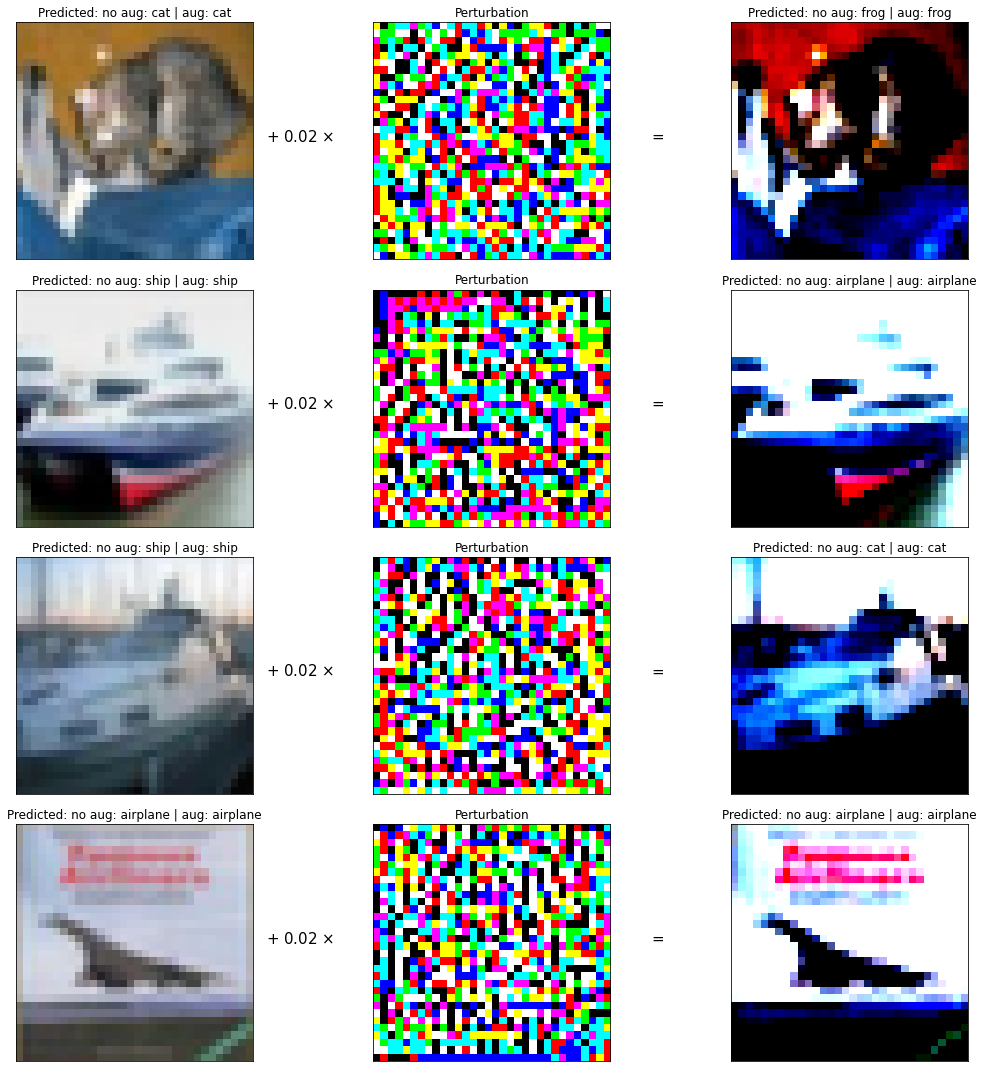

In [46]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu

output = classifier(adv_imgs.to(DEVICE, dtype=torch.float))
output_aug = classifier_aug(adv_imgs.to(DEVICE, dtype=torch.float))
adv_pred = torch.argmax(output, 1)
adv_pred_aug = torch.argmax(output, 1)

def denorm(tensor):
    d = std.view(3,1,1) * tensor + mean.view(3,1,1)
    d[d < 1e-8] = 0
    return d

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
# denormalizacja obrazków i reszta w sumie tak samo jak wyżej
for row, img, adv, p, adv_p, p2, adv_p2, g in zip(axes, denorm(images), adv_imgs, pred, adv_pred, pred_aug, adv_pred_aug, grads):
    row[0].imshow(img.detach().numpy().transpose(1,2,0))
    row[0].set_title(f"Predicted: no aug: {classes[p]} | aug: {classes[p2]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(g.numpy().transpose(1,2,0))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(adv.detach().numpy().transpose(1,2,0))
    row[2].set_title(f"Predicted: no aug: {classes[adv_p]} | aug: {classes[adv_p2]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()